In [ ]:
#!git clone https://github.com/PauloHFS/gpt2-from-scratch.git

In [ ]:
#%cd gpt2-from-scratch

# GPT From Scratch

Este repositório irá implementar o GPT 2 do zero, com o código bruto do modelo presente na pasta `src`.

O objetivo será realizar o seguinte fluxo de atividades:
* Leitura do dataset;
* Treina modelo;
* Plotagem de métricas durante treino;
* Processa modelo para gerar textos;
* Avaliação dos textos;
* Plotagem da avaliação;
* Conclusão.

---

# Preparando ambiente

Importando pacotes python para utilização do código

In [1]:
# Importando pacotes python

from os import mkdir, environ
from os.path import exists

from json import load

import torch
from torch.nn.functional import cross_entropy
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

np.random.seed(42)
torch.manual_seed(42)

Importando pacotes para execução do experimento

In [2]:
from src.dataload.tokenizer import Tokenizer
from src.gptmodel.model import GPTModel
from src.gptmodel.gqa_model import GQAModel

---

# Configurações para rodar o sistema

Aqui ocorrerá as constantes para o processamento do sistema:

In [3]:
RESULT_DIR = "results"

if not exists(RESULT_DIR): mkdir(RESULT_DIR)

Diretório de banco de dados:

In [4]:
DATASET_DIR = "dataset/"

Caminho final dos tokens:

In [5]:
TOKEN_TEXTS = f"{RESULT_DIR}/tokens.txt"

Caminho do melhor modelo:

In [6]:
BEST_MODEL_PATH = f"{RESULT_DIR}/best_model.pt"

Configuração do GPT:

In [7]:
GPT_CONFIGURATION = f"src/gpt_configurations.json"

Estatísticas:

In [8]:
TRAIN_RATIO = 0.8
BATCH_SIZE = 5

Configuração:

In [9]:
with open(GPT_CONFIGURATION, 'r') as f:
    CONFIGURATION = load(f)

In [10]:
CONFIGURATION_KEY = "GPT_CONFIG_SMALL_COLAB"
CONFIGURATION_KEY_GQA = "GQA_CONFIG"

In [11]:
configuration = CONFIGURATION[CONFIGURATION_KEY]
configuration_gqa = CONFIGURATION[CONFIGURATION_KEY_GQA]

In [12]:
configuration

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 256,
 'n_heads': 8,
 'n_layers': 8,
 'drop_rate': 0.1,
 'qkv_bias': False,
 'attention_type': 'gqa',
 'num_kv_groups': 4}

In [13]:
configuration_gqa

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 256,
 'n_heads': 12,
 'n_layers': 12,
 'hidden_dim': 768,
 'head_dim': 256,
 'qk_norm': True,
 'n_kv_groups': 4,
 'rope_base': 1000000.0,
 'dtype': 'torch.bfloat16'}

Ambientes de execução:

In [14]:
environ['CUDA_LAUNCH_BLOCKING'] = "1"

---

# Leitura do Dataset

Tokenizando todo o conjunto de dados para treinamento e salvando em um arquivo de texto:

In [15]:
tokenizer = Tokenizer(["utf-8", "latin1"])

In [16]:
tokenizer.generate_data(DATASET_DIR, TOKEN_TEXTS)

100%|██████████| 10/10 [00:00<00:00, 53.23it/s]


Carregando base de dados:

In [17]:
with open(TOKEN_TEXTS, 'r', encoding='utf-8') as f:
    contents = f.read()

In [18]:
train_dataloader, test_dataloader = tokenizer.create_dataloaders(
    contents,
    TRAIN_RATIO,
    BATCH_SIZE,
    configuration["context_length"],
    configuration["context_length"]
    )

---

# Treino dos modelos

Esta seção irá ocorrer a instanciação e geração dos modelos:

In [19]:
model = GPTModel(
    vocab_size=configuration["vocab_size"],
    emb_dim=configuration["emb_dim"],
    context_length=configuration["context_length"],
    drop_rate=configuration["drop_rate"],
    n_heads=configuration["n_heads"],
    n_layers=configuration["n_layers"],
    qkv_bias=configuration["qkv_bias"]
    )

In [20]:
model_gqa = GQAModel(
    configuration_gqa
)

In [21]:
print(torch.cuda.is_available())


True


In [22]:
trained_models, final_metrics = GQAModel._train(
    model=model,
    train_loader=train_dataloader,
    val_loader=test_dataloader,
    device_str="cuda",
    path=BEST_MODEL_PATH)

Training model on device: cuda


  0%|          | 0/1 [01:34<?, ?it/s]

Epoch 1/1 | Step 200 - Train Loss: 5.4689, Val Loss 5.1399, Throughput: 4062.3 tokens / sec


  0%|          | 0/1 [01:35<?, ?it/s]

New best model saved to results/best_model.pt with val_loss: 5.1399


  0%|          | 0/1 [03:04<?, ?it/s]

Epoch 1/1 | Step 400 - Train Loss: 4.6664, Val Loss 4.5844, Throughput: 3554.7 tokens / sec


  0%|          | 0/1 [03:04<?, ?it/s]

New best model saved to results/best_model.pt with val_loss: 4.5844


  0%|          | 0/1 [04:47<?, ?it/s]

Epoch 1/1 | Step 600 - Train Loss: 4.3707, Val Loss 4.3407, Throughput: 2843.8 tokens / sec


  0%|          | 0/1 [04:48<?, ?it/s]

New best model saved to results/best_model.pt with val_loss: 4.3407


100%|██████████| 1/1 [05:53<00:00, 353.49s/it]


---

# Análise de treinamento

Nesta seção irá ocorrer a análise do treinamento do modelo:

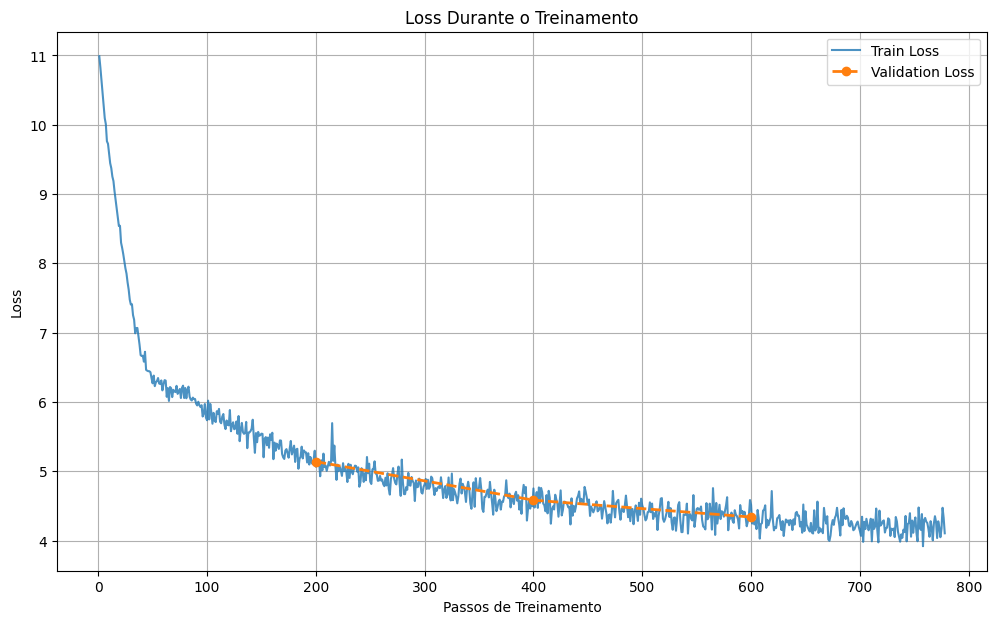

In [23]:
val_interval = 200

num_val_points = len(final_metrics.val_loss)
val_steps = np.arange(1, num_val_points + 1) * val_interval

fig = plt.figure(figsize=(12, 7))

plt.plot(
    np.arange(1, len(final_metrics.train_loss) + 1),
    final_metrics.train_loss,
    label='Train Loss',
    alpha=0.8
)

plt.plot(
    val_steps,
    final_metrics.val_loss,
    label='Validation Loss',
    marker='o',
    linestyle='--',
    linewidth=2
)

plt.xlabel('Passos de Treinamento')
plt.ylabel('Loss')
plt.title('Loss Durante o Treinamento')
plt.legend()
plt.grid(True)
plt.show()

O gráfico exibe uma curva de aprendizado clássica e saudável. O treinamento iniciou com uma loss elevada (superior a 11.0), valor consistente com a performance de um modelo não treinado em um vocabulário extenso. Observa-se uma queda acentuada e rápida da loss nos passos iniciais (0-200), indicando que o modelo ajustou seus pesos eficientemente no começo do treinamento. A taxa de aprendizado diminui progressivamente, e a curva começa a se estabilizar em passos mais avançados, sugerindo que o modelo está convergindo.

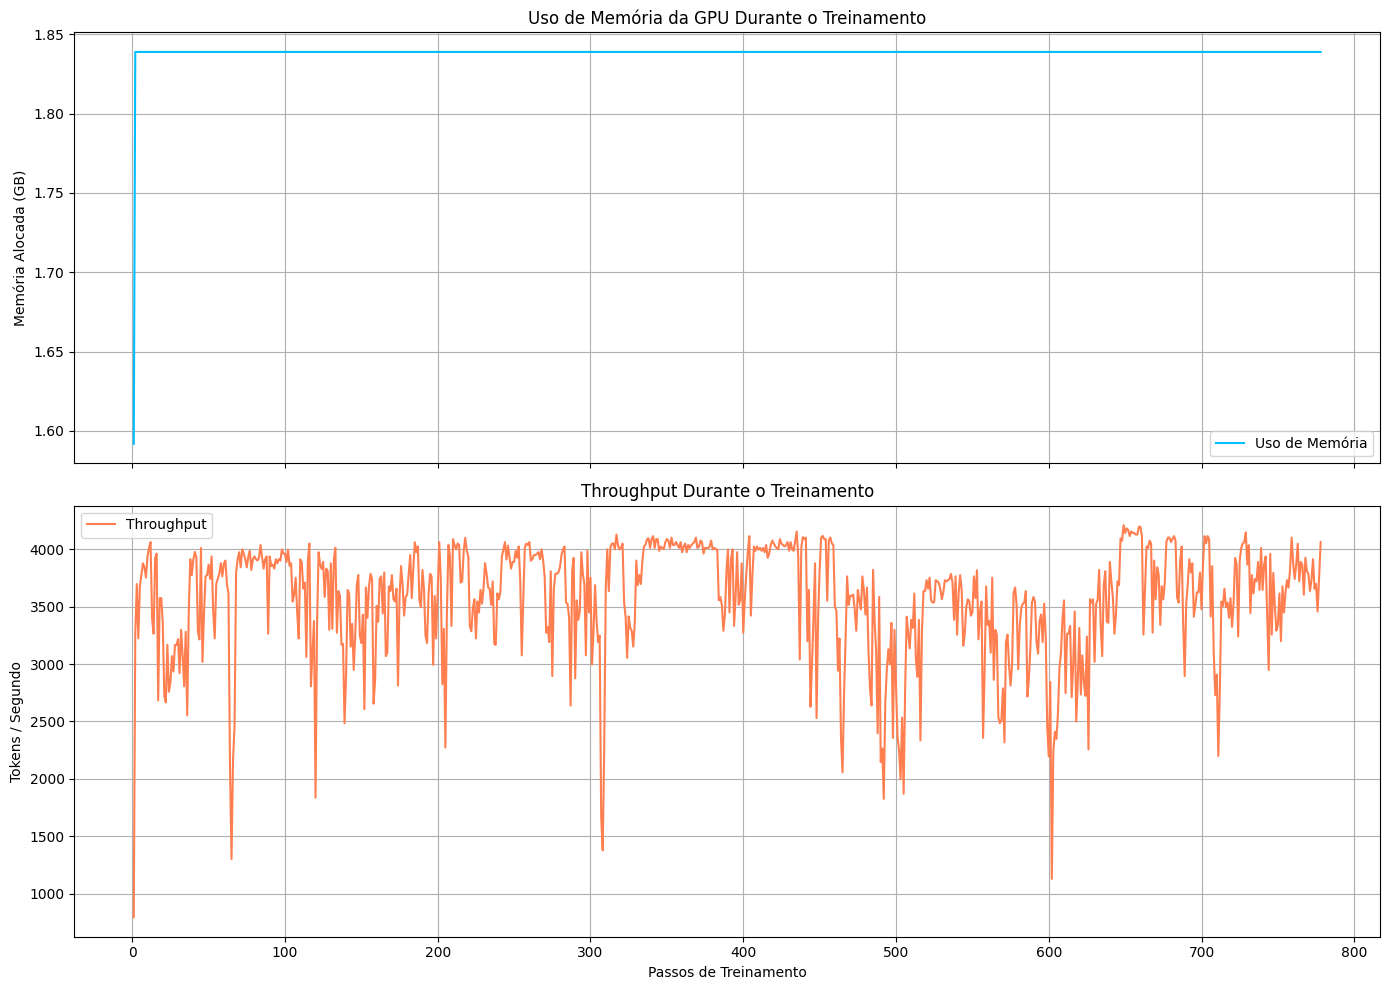

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(
    np.arange(1, len(final_metrics.gpu_memory) + 1),
    final_metrics.gpu_memory,
    color='deepskyblue',
    label='Uso de Memória'
)
axes[0].set_title('Uso de Memória da GPU Durante o Treinamento')
axes[0].set_ylabel('Memória Alocada (GB)')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(
    np.arange(1, len(final_metrics.throughput) + 1),
    final_metrics.throughput,
    color='coral',
    label='Throughput'
)
axes[1].set_title('Throughput Durante o Treinamento')
axes[1].set_ylabel('Tokens / Segundo')
axes[1].grid(True)
axes[1].legend()

plt.xlabel('Passos de Treinamento')

plt.tight_layout()

plt.show()

O uso de memória da GPU é constante, o que é bom, o sistema está estável. Já quanto ao throughput, o desempenho médio é alto, indicando processamento eficiente. No entanto, a alta variância e as quedas periódicas acentuadas revelam que o treinamento é limitado por gargalos de I/O (carregamento de dados, escrita de logs), não pela capacidade computacional da GPU.

---

# Geração de Textos para avaliação

Esta seção irá ocorrer a geração de textos para avaliação:

In [ ]:
BEST_MODEL_PATH = "results/best_model.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = GPTModel(
    vocab_size=configuration["vocab_size"],
    emb_dim=configuration["emb_dim"],
    context_length=configuration["context_length"],
    drop_rate=configuration["drop_rate"],
    n_heads=configuration["n_heads"],
    n_layers=configuration["n_layers"],
    qkv_bias=configuration["qkv_bias"],
)

model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.to(device)
model.eval()

tokenizer = AutoTokenizer.from_pretrained("gpt2")
eos_token_id = tokenizer.eos_token_id

prompt_text = "Inteligência Artificial é um campo da ciência da computação"
encoded_prompt = tokenizer.encode(prompt_text, return_tensors="pt").to(device)

print(f"Prompt: '{prompt_text}'\n")

with torch.no_grad():
    output_tokens = model.generate(
        idx=encoded_prompt,
        max_new_tokens=100,
        context_size=configuration["context_length"],
        temperature=0.7,
        top_k=50,
        eos_id=eos_token_id
    )

decoded_text = tokenizer.decode(output_tokens[0])

print("-"*50)
print(decoded_text)

O texto gerado é incoerente porque o modelo está subtreinado devido aos poucos dados, 8 livros é um material insuficiente para o modelo aprender a complexidade da língua portuguesa. Além disso o pouco treinamento, apenas uma época de treinamento não foi o bastante para o modelo aprender nem mesmo com os poucos dados disponíveis.

---

# Avaliação dos textos

Esta seção irá ocorrer a avaliação dos textos gerados pela LLM, tanto numericamente como graficamente.

In [ ]:
def calculate_perplexity(model, dataloader, device):
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for input_ids, target_ids in dataloader:
            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)

            logits = model(input_ids)

            loss = cross_entropy(
                logits.view(-1, logits.size(-1)),
                target_ids.view(-1)
            )

            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / num_batches
    perplexity = np.exp(avg_loss)
    return perplexity

ppl = calculate_perplexity(model, test_dataloader, device)

print(f"Perplexidade no conjunto de teste: {ppl:.2f}")

Surpreendentemente, este valor é bom para um treinamento tão inicial. Mostra que o modelo já está aprendendo padrões e não está "chutando" aleatoriamente. A métrica confirma que o treinamento está funcionando e na direção correta, apesar de a geração de texto ainda ser incoerente.

---

# Conclusão

Por fim, aqui teremos uma seção de feedback a respeito das atividades desenvolvidas!